In [1]:
import os
import torch
import matplotlib.pyplot as plt
import xml.dom.minidom
from skimage.io import imread
from skimage import img_as_ubyte
from pyrr import Matrix44, Vector4, Vector3
import pyrr

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes

# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures
from pytorch3d.renderer import (
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    HardPhongShader
)
from pytorch3d.renderer.cameras import look_at_view_transform
from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)

from torch_openpose.body import Body
from torch_openpose import util
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm

from tqdm import tqdm
import torch.nn as nn
import imageio
import cv2
import copy

import wandb

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))
import pytorch3d

In [24]:
def transform_node_to_matrix(node):
    model_matrix = np.identity(4)
    for child in reversed(node.childNodes):
        if child.nodeName == "translate":
            x = float(child.getAttribute('x'))
            y = float(child.getAttribute('y'))
            z = float(child.getAttribute('z'))
            z *= -1
            translate_vec = Vector3([x, y, z])
            trans_matrix = np.transpose(pyrr.matrix44.create_from_translation(translate_vec))
            model_matrix = np.matmul(model_matrix, trans_matrix)
        if child.nodeName == "scale":
            scale = float(child.getAttribute('value'))
            scale_vec = Vector3([scale, scale, scale])
            scale_matrix = np.transpose(pyrr.matrix44.create_from_scale(scale_vec))
            model_matrix = np.matmul(model_matrix, scale_matrix)
            
    return model_matrix

def transform_node_to_R_T(node):
    eye = node.getAttribute('origin').split(',')
    eye = [float(i) for i in eye]
    at = node.getAttribute('target').split(',')
    at = [float(i) for i in at]
    up = node.getAttribute('up').split(',')
    up = [float(i) for i in up]
    
    R, T = look_at_view_transform(
        eye=[eye], 
        at=[at], 
        up=[up]
    )
    return R, T

def load_shape(shape):
    if shape is None:
        return None
    device = torch.device("cuda:0")
    char_filename_node = shape.getElementsByTagName('string')[0]
    char_filename = char_filename_node.getAttribute('value')
    obj_filename = os.path.join(DATA_ROOT, char_filename)
    mesh = load_objs_as_meshes([obj_filename], device=device)
    verticies, faces = mesh.get_mesh_verts_faces(0)
    texture = mesh.textures.clone() if mesh.textures is not None else None
    
    
    
    transform_node = shape.getElementsByTagName('transform')
    if len(transform_node) == 0:
        verticies[:, 2] *= -1
        return verticies, faces, texture
    # apply transform
    transform_node = transform_node[0]
    model_matrix =  transform_node_to_matrix(transform_node)
    model_matrix = torch.from_numpy(model_matrix).cuda().double() 
    
    # make coordiantes homegenos
    new_row = torch.ones(1, verticies.shape[0], device=device)
    vetrices_homo = torch.cat((verticies.t(), new_row)).double() 
    
    # transform
    vetrices_world = torch.chain_matmul(model_matrix, vetrices_homo).t()[:, :3]
    return vetrices_world.float(), faces, texture

def mitsuba_scene_to_torch_3d(master_scene):
    device = torch.device("cuda:0")
    master_doc = xml.dom.minidom.parse(master_scene)
    camera = master_doc.getElementsByTagName('sensor')[0]
    camera_transform = camera.getElementsByTagName('transform')[0]
    R, T = transform_node_to_R_T(camera_transform.getElementsByTagName('lookat')[0])

    cameras = OpenGLPerspectiveCameras(
        znear=0.1,
        zfar=10000,
        fov=15,
        degrees=True,
        device=device, 
        R=R, 
        T=T
    )
    
    
    character = None
    tshirt = None
    ground = None
    
    shapes = master_doc.getElementsByTagName('shape')
    for i in range(len(shapes)):
        if shapes[i].getAttribute("id") == 'character':
            character = shapes[i]
        if shapes[i].getAttribute("id") == 'simulated':
            tshirt = shapes[i]
        if shapes[i].getAttribute("id") == 'place.000000':
            ground = shapes[i]
    

    character_vetrices, character_faces, character_texture = load_shape(character)
    
    tex2 = torch.ones_like(character_vetrices).cuda()

    # person
    tex2[:, 0] *= 0.88
    tex2[:, 1] *= 0.67
    tex2[:, 2] *= 0.41
    
    tex = torch.cat([tex2])[None]  # (1, 204, 3)
    textures = Textures(verts_rgb=tex.cuda())
    
    verts = torch.cat([character_vetrices]).cuda()  #(204, 3)
    
    faces = torch.cat([character_faces]).cuda()  
    mesh = Meshes(verts=[verts], faces=[faces], textures=textures)
    
    optmization_input = {
        "textures": textures,
        "verticies": verts, 
        "faces": faces
    }
        
    return mesh, cameras, optmization_input

class Model(nn.Module):
    def __init__(self, texTshirt, texOther, verticies, faces, renderer, body_estimation):
        super().__init__()
        self.device = torch.device("cuda:0")
        self.renderer = renderer
        self.texOther = texOther
        self.texTshirt = texTshirt
        self.verticies = verticies
        self.faces = faces
        self.body_estimation = body_estimation
        self.cur_mesh = None
        
        self.vertex_displacements = nn.Parameter(
            torch.zeros_like(verticies).to(self.device)
        )
        
        ## loss functions
        self.objective = torch.nn.MSELoss()
        self.zero_heatmap = torch.zeros((1, 19, 64, 64), device=self.device)
        self.zero_paf = torch.zeros((1, 38, 64, 64), device=self.device)

    def forward(self):
        tex = torch.cat([self.texTshirt, self.texOther])[None]  # (1, 204, 3)
        textures = Textures(verts_rgb=tex.cuda())
        
        cur_vertices = self.verticies + self.vertex_displacements
        
        self.cur_mesh = Meshes(verts=[cur_vertices], faces=[self.faces], textures=textures)
        images = self.renderer(self.cur_mesh)
        
        #
        body_input = (images[..., :3] - 0.5).permute((0, 3, 1, 2)).float()
        paf, heat = self.body_estimation.model(body_input)
        
        ob_val_heat = self.objective(heat, self.zero_heatmap)
        ob_val_paf = self.objective(paf, self.zero_paf)
        
        # Calculate the silhouette loss
        loss = ob_val_heat + ob_val_paf
        return loss, images
    
def get_body_image_from_mesh(cur_mesh, body_estimation, renderer):
    images = renderer(cur_mesh)
        
    rendering_torch_input = (images[..., :3] - 0.5).permute((0, 3, 1, 2)).float()
    
    heatmap_avg, paf_avg = body_estimation.compute_heatmap_paf_avg(rendering_torch_input, ORIG_SHAPE)
    candidate, subset = body_estimation.get_pose(heatmap_avg, paf_avg, ORIG_SHAPE)
    rendering_torch_np =  images[0, ..., :3].detach().squeeze().cpu().numpy()
    canvas = copy.deepcopy(rendering_torch_np)
    canvas = util.draw_bodypose(canvas, candidate, subset)
    
    return canvas, candidate, subset, heatmap_avg, paf_avg

def wandb_init(name):
    run = wandb.init(
        project = "pose_opt", 
        reinit = True,
        name = name,
        config={
            "steps": 250,
            "learning_rate": 0.2
        }
    )
    
    return run 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Target')

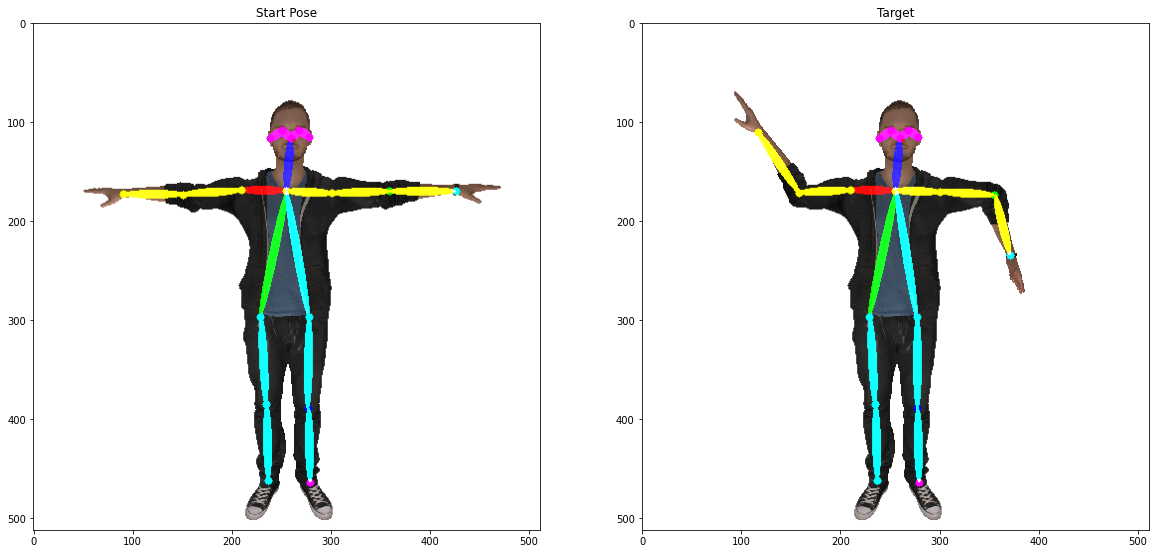

In [25]:
ORIG_SHAPE = (512, 512, 3)
DATA_ROOT = '../data/tshirt_torch/train'

ORIG_SHAPE = (512, 512, 3)

body_estimation = Body('/home/ax/data/programs/pytorch-openpose/model/body_pose_model.pth', True)

# set defaults
body_estimation.imageToTest_padded_shape = ORIG_SHAPE
body_estimation.pad = [0, 0, 0, 0]

# Setup
device = torch.device("cuda:0")
torch.cuda.set_device(device)

# Set paths
obj_filename = '../openPose/data_set_creator/pose_0_1.obj'
obj_filename_target = '../openPose/data_set_creator/pose_0_3.obj'

# Load obj file
mesh = load_objs_as_meshes([obj_filename], device=device)
target_mesh = load_objs_as_meshes([obj_filename_target], device=device)

texture_image = mesh.textures.maps_padded()
verticies = mesh.verts_list()
verticies[0].requires_grad = True

faces = mesh.faces_list()
texture = mesh.textures.clone()
maps = texture.maps_padded()
faces_uvs = texture.faces_uvs_padded()
verts_uvs = texture.verts_uvs_padded()
verts_rgb = texture.verts_rgb_padded()
new_texture = Textures(maps, faces_uvs, verts_uvs, verts_rgb)

new_mesh = Meshes(verticies, faces, new_texture)

R, T = look_at_view_transform(200.0, 10, 0) 
T[0, 1] = -100
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)

raster_settings = RasterizationSettings(
    image_size=512, 
    blur_radius=0.0, 
    faces_per_pixel=1,
    perspective_correct=True,
    bin_size=64
)
lights = PointLights(device=device, location=[[0.0, 50.0, 50.0]])

renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ), 
    shader=TexturedSoftPhongShader(
        device=device, 
        cameras=cameras, 
        lights=lights
    )
)


canvas_orig, *_ = get_body_image_from_mesh(new_mesh, body_estimation, renderer)
canvas_target, *_ = get_body_image_from_mesh(target_mesh, body_estimation, renderer)




fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(canvas_orig)

ax.set_title("Start Pose")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(canvas_target)
ax.set_title("Target")

In [26]:
class Model(nn.Module):
    def __init__(self, target_mesh, verticies, faces, texture, renderer, body_estimation):
        super().__init__()
        self.device = torch.device("cuda:0")
        self.renderer = renderer
        self.texture = texture
        self.verticies = verticies
        self.faces = faces
        self.body_estimation = body_estimation
        self.cur_mesh = None
        self.target_mesh = target_mesh
        
        self.vertex_displacement = nn.Parameter(
            torch.zeros_like(verticies).to(self.device)
        )
        
        
        
        ## loss functions
        self.objective = torch.nn.MSELoss()
        self.zero_heatmap = torch.zeros((1, 19, 64, 64), device=self.device)
        
        target_images = self.renderer(self.target_mesh)
        target_body_input = (target_images[..., :3] - 0.5).permute((0, 3, 1, 2)).float()
        paf, heat = self.body_estimation.model(target_body_input)
        
        self.target_paf = paf
        self.target_heat = heat

    def forward(self):
        w_edge = 0.1 
        # Weight for mesh normal consistency
        w_normal = 0.1 
        # Weight for mesh laplacian smoothing
        w_laplacian = 0.1 
        # Weight for heatmap
        w_pose = 2000
        
        cur_verticies = self.verticies + self.vertex_displacement
        self.cur_mesh = Meshes(cur_verticies, self.faces, self.texture)
        
        images = self.renderer(self.cur_mesh)
        
        body_input = (images[..., :3] - 0.5).permute((0, 3, 1, 2)).float()
        paf, heat = self.body_estimation.model(body_input)
        
        ob_val_heat = self.objective(heat, self.target_heat)
        ob_val_paf = self.objective(paf, self.target_paf)
        
        # and (b) the edge length of the predicted mesh
        loss_edge = mesh_edge_loss(self.cur_mesh)

        # mesh normal consistency
        loss_normal = mesh_normal_consistency(self.cur_mesh)

        # mesh laplacian smoothing
        loss_laplacian = mesh_laplacian_smoothing(self.cur_mesh, method="uniform")
        
        # Calculate the silhouette loss
        loss = w_pose * (ob_val_heat + ob_val_paf) + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian
        return loss, images

In [27]:
# Initialize a model using the renderer, mesh and reference image
model = Model(
    target_mesh=target_mesh,
    verticies=torch.stack(verticies), 
    faces=torch.stack(faces),
    texture=new_texture,
    renderer=renderer,
    body_estimation=body_estimation
).to(device)

# Create an optimizer. Here we are using Adam and we pass in the parameters of the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
filename_output = "./texture_single_pose.gif"
run = wandb_init('singleViewReg')
writer = imageio.get_writer(filename_output, mode='I', duration=0.3)

In [28]:
for i in tqdm(range(run.config.steps)):
    optimizer.zero_grad()
    loss, cur_image = model()
    loss.backward(retain_graph=True)
    optimizer.step()
    wandb.log({'loss': loss.item()}, step=i)
    
    # Save outputs to create a GIF. 
    
    image = cur_image[0, ..., :3].detach().squeeze().cpu().numpy()
    image = np.clip(image, -1, 1)
    image = img_as_ubyte(image)
    writer.append_data(image)
    
writer.close()

100%|██████████| 250/250 [04:38<00:00,  1.11s/it]


![SegmentLocal](texture_single_pose.gif "segment")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Target')

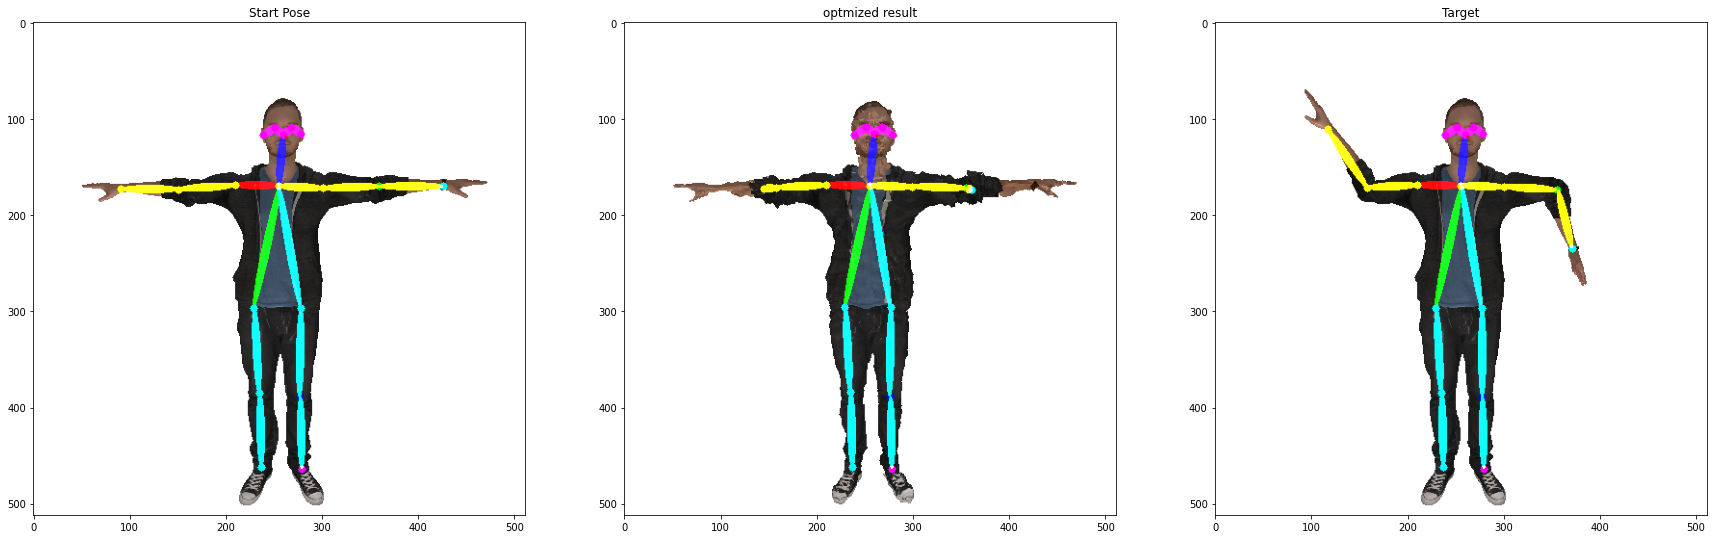

In [29]:
canvas_orig, *_ = get_body_image_from_mesh(new_mesh, body_estimation, renderer)
canvas_opt, *_ = get_body_image_from_mesh(model.cur_mesh, body_estimation, renderer)
canvas_target, *_ = get_body_image_from_mesh(target_mesh, body_estimation, renderer)




fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(canvas_orig)
ax.set_title("Start Pose")

ax = fig.add_subplot(1, 3, 2)
ax.imshow(canvas_opt)
ax.set_title("optmized result")

ax = fig.add_subplot(1, 3, 3)
ax.imshow(canvas_target)
ax.set_title("Target")